### Code for generation of integrated anndata object
_Integrative analysis of cell state changes in lung fibrosis with peripheral protein biomarkers'_ 
in EMBO Molecular Medicine. <br> 
Christoph H. Mayr, Lukas M. Simon, Gabriela Leuschner, et al. and Fabian J. Theis, Herbert Schiller

In [1]:
## This Notebook generates the anndata object that is further used in the remaining Script
## raw counts for additional Chicago and Nashville Patients were obtained from 2 recent publications 
## Chicago (Reyfman PA et al, 2018) and Nashville (Habermann AC et al, 2019)

import scanpy as sc
import bbknn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from scipy import sparse
import warnings
warnings.filterwarnings("ignore")

from matplotlib import colors
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

plt.rcParams['figure.figsize'] = (6, 5)
folder = "~/20200210_Schiller_humanILD_meshal.ansari/"

sc.logging.print_version_and_date()

Running Scanpy 1.6.1.dev110+gb4234d81, on 2021-02-11 12:56.


### Define Functions used in this Notebook

In [2]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

def scran_normalize(adata_pp):
    ## Perform coarse clustering for Scran Normalization
    data = adata_pp.X.todense().T
    sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after = 1e6)
    sc.pp.log1p(adata_pp)
    sc.pp.highly_variable_genes(adata_pp, flavor = "cell_ranger", n_top_genes = 4000, subset = False)
    sc.pp.pca(adata_pp, n_comps = 15, use_highly_variable = True)
    sc.pp.neighbors(adata_pp)
    sc.tl.louvain(adata_pp, key_added = "groups", resolution = 1)

    #Preprocess variables for scran normalization
    input_groups = adata_pp.obs["groups"]
    %R -i data -i input_groups -o size_factors size_factors = computeSumFactors(data, clusters = input_groups, min.mean = 0.1)
    return size_factors


In [3]:
%%R
suppressPackageStartupMessages(library(scran))

In [4]:
all_genes = pd.read_csv(folder + "integrated_cohorts_genes.txt", header = None).iloc[:, 0].values
meta = pd.read_csv(folder + "integrated_cohorts_metadata.txt", sep = "\t", index_col = 0)
cc_genes = [x.strip() for x in open(folder + "regev_lab_cell_cycle_genes.txt")]
all_hvgs = pd.read_csv(folder + "integrated_cohorts_hvgs.txt", sep = "\t", header = None).iloc[:, 0].values

### 1) Pre-process Munich Cohort

In [5]:
munich = sc.read(folder + "munich_cohort_raw_counts.mtx")
munich.obs_names = pd.read_csv(folder + "munich_cohort_barcodes.txt", header = None).iloc[:, 0].values
munich.var_names = all_genes
munich.obs = meta.iloc[:, 2:].loc[munich.obs_names]

sc._utils.sanitize_anndata(munich)
munich

... storing 'patient_id' as categorical
... storing 'data_set' as categorical
... storing 'phase' as categorical
... storing 'disease' as categorical
... storing 'Sex' as categorical
... storing 'Smoking Status' as categorical
... storing 'Smoking History' as categorical
... storing 'health_status' as categorical
... storing 'cell_type' as categorical
... storing 'cell_state_label' as categorical
... storing 'tissue_label' as categorical


AnnData object with n_obs × n_vars = 38648 × 38615
    obs: 'patient_id', 'data_set', 'doublet_scores', 'S_score', 'G2M_score', 'phase', 'disease', 'Age', 'Sex', 'Smoking Status', 'Smoking History', 'health_status', 'louvain', 'cell_type', 'cell_state_label', 'tissue_label', 'n_counts', 'n_genes', 'size_factors'

In [6]:
## Keep the count data in a counts layer
munich.layers["counts"] = sparse.csr_matrix(munich.X)

## Normalize adata using Scran’s size factor based approach and log-transform
# munich.obs["size_factors"] = scran_normalize(munich)
munich.X /= munich.obs['size_factors'].values[:,None]
sc.pp.log1p(munich)
munich.X = sparse.csr_matrix(munich.X)

# Store the full data set in 'raw' as log-normalised data for statistical testing
munich.raw = sc.AnnData(X = sparse.csr_matrix(munich.X))
munich.raw.var.index = munich.var_names.values

In [7]:
## Highly variable gene Selection per Patient
sc.pp.highly_variable_genes(munich, batch_key = "patient_id", n_bins = 20, flavor = "cell_ranger", subset = False)
vartab_m = pd.DataFrame(munich.var["highly_variable_nbatches"], index = munich.var_names)
print(sum(vartab_m.highly_variable_nbatches.values > 2))

4291


In [8]:
## Regress and Scale per Dataset
sc.pp.filter_genes(munich, min_counts = 1)
sc.pp.regress_out(munich, ["S_score", "G2M_score", "percent.mito", "n_counts"])
sc.pp.scale(munich)

### 2) Pre-process Chicago Cohort

In [9]:
chicago = sc.read(folder + "chicago_cohort_raw_counts.mtx")
chicago.obs_names = pd.read_csv(folder + "chicago_cohort_barcodes.txt", header = None).iloc[:, 0].values
chicago.var_names = all_genes
chicago.obs = meta.iloc[:, 2:].loc[chicago.obs_names]

sc._utils.sanitize_anndata(chicago)
chicago

... storing 'patient_id' as categorical
... storing 'data_set' as categorical
... storing 'phase' as categorical
... storing 'disease' as categorical
... storing 'Sex' as categorical
... storing 'Smoking Status' as categorical
... storing 'Smoking History' as categorical
... storing 'health_status' as categorical
... storing 'cell_type' as categorical
... storing 'cell_state_label' as categorical
... storing 'tissue_label' as categorical


AnnData object with n_obs × n_vars = 80919 × 38615
    obs: 'patient_id', 'data_set', 'doublet_scores', 'S_score', 'G2M_score', 'phase', 'disease', 'Age', 'Sex', 'Smoking Status', 'Smoking History', 'health_status', 'louvain', 'cell_type', 'cell_state_label', 'tissue_label', 'n_counts', 'n_genes', 'size_factors'

In [10]:
#Keep the count data in a separate layer
chicago.layers["counts"] = sparse.csr_matrix(chicago.X)

## Normalize adata using Scran’s size factor based approach and log-transform
# chicago.obs["size_factors"] = scran_normalize(chicago)
chicago.X /= chicago.obs['size_factors'].values[:,None]
sc.pp.log1p(chicago)
chicago.X = sparse.csr_matrix(chicago.X)

# Store the full data set in 'raw' as log-normalised data for statistical testing
chicago.raw = sc.AnnData(X = sparse.csr_matrix(chicago.X))
chicago.raw.var.index = chicago.var_names.values

In [11]:
## Highly variable gene Selection per Patient
sc.pp.highly_variable_genes(chicago, batch_key = "patient_id", n_bins = 20, flavor = "cell_ranger", subset = False)
vartab_c = pd.DataFrame(chicago.var["highly_variable_nbatches"], index = chicago.var_names)

In [12]:
## Regress and Scale per Dataset
sc.pp.filter_genes(chicago, min_counts = 1)
sc.pp.regress_out(chicago, ["S_score", "G2M_score", "percent.mito", "n_counts"])
sc.pp.scale(chicago)

### 3) Pre-process Nashville Cohort

In [13]:
nashville = sc.read(folder + "nashville_cohort_raw_counts.mtx")
nashville.obs_names = pd.read_csv(folder + "nashville_cohort_barcodes.txt", header = None).iloc[:, 0].values
nashville.var_names = all_genes
nashville.obs = meta.iloc[:, 2:].loc[nashville.obs_names]

sc._utils.sanitize_anndata(nashville)
nashville

... storing 'patient_id' as categorical
... storing 'data_set' as categorical
... storing 'phase' as categorical
... storing 'disease' as categorical
... storing 'Sex' as categorical
... storing 'Smoking Status' as categorical
... storing 'Smoking History' as categorical
... storing 'health_status' as categorical
... storing 'cell_type' as categorical
... storing 'cell_state_label' as categorical
... storing 'tissue_label' as categorical


AnnData object with n_obs × n_vars = 114396 × 38615
    obs: 'patient_id', 'data_set', 'doublet_scores', 'S_score', 'G2M_score', 'phase', 'disease', 'Age', 'Sex', 'Smoking Status', 'Smoking History', 'health_status', 'louvain', 'cell_type', 'cell_state_label', 'tissue_label', 'n_counts', 'n_genes', 'size_factors'

In [18]:
#Keep the count data in a separate layer
nashville.layers["counts"] = sparse.csr_matrix(nashville.X)

## Normalize adata using Scran’s size factor based approach and log-transform
# nashville.obs["size_factors"] = scran_normalize(nashville)
nashville.X /= nashville.obs['size_factors'].values[:, None]
sc.pp.log1p(nashville)
nashville.X = sparse.csr_matrix(nashville.X)

# Store the full data set in 'raw' as log-normalised data for statistical testing
nashville.raw = sc.AnnData(X = sparse.csr_matrix(nashville.X))
nashville.raw.var.index = nashville.var_names.values

In [19]:
## Highly variable gene Selection per Patient
sc.pp.highly_variable_genes(nashville, batch_key = "patient_id", n_bins = 20, flavor = "cell_ranger", subset = False)
vartab_n = pd.DataFrame(nashville.var["highly_variable_nbatches"], index = nashville.var_names)

In [20]:
## Regress and Scale per Dataset
sc.pp.filter_genes(nashville, min_counts = 1)
sc.pp.regress_out(nashville, ["S_score", "G2M_score", "percent.mito", "n_counts"])
sc.pp.scale(nashville)

### Integrate the separately pre-processed Cohorts

In [21]:
adata = munich.concatenate([chicago, nashville], batch_key = "data_set", join = "outer", index_unique = None)
sc._utils.sanitize_anndata(adata)
adata.obs.data_set.cat.categories = ["Munich", "Chicago", "Nashville"]

... storing 'patient_id' as categorical
... storing 'disease' as categorical
... storing 'Smoking Status' as categorical
... storing 'Smoking History' as categorical
... storing 'cell_type' as categorical
... storing 'cell_state_label' as categorical


#### Select Variable Genes

In [22]:
## Original selection of highly variablte genes for integrated object

## Keep those genes variable in at least 3 Patient for Chicago and in at least 2 Patients for Munich Data Set
# all_hvgs = vartab_m[vartab_m.highly_variable_nbatches.values > 1].index
# all_hvgs = np.intersect1d(all_hvgs, vartab_c[vartab_c.highly_variable_nbatches.values > 2].index)
## Remove Cell cycle Genes from list of variable genes
# all_hvgs = np.setdiff1d(all_hvgs, cc_genes)

## Set hvgs based on exported list
adata.var["highly_variable"] = [g in all_hvgs for g in adata.var_names]
sum(adata.var["highly_variable"])

3854

In [23]:
## Original Parameters for PCA and Visualization
# bbknn.bbknn(adata, batch_key = "all_patients", neighbors_within_batch = 10, n_pcs = 40)
# sc.tl.louvain(adata, resolution = 1)
# sc.tl.umap(adata)

## Set Coordinates based on meta file to be consistend with figures
adata.obsm["X_umap"] = meta.loc[adata.obs_names, ["umap_1", "umap_2"]].values

#### Figure 2 a) UMAP of single cell transcriptomic data coloured by patient cohort

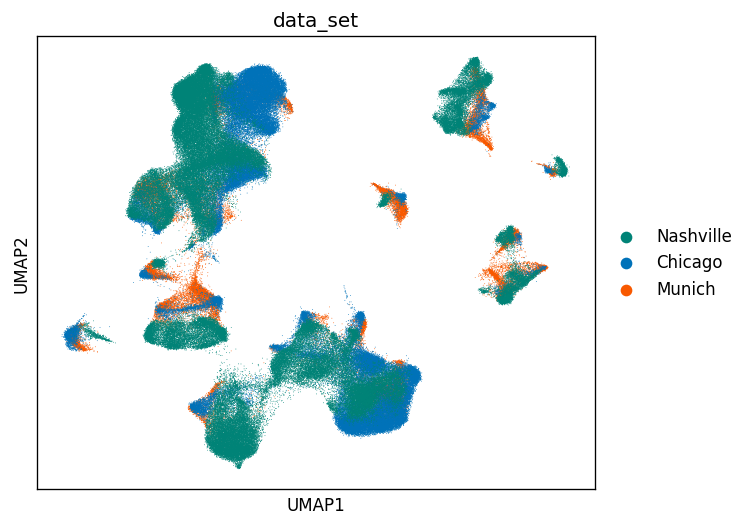

In [28]:
adata.obs.data_set.cat.reorder_categories(["Nashville", "Chicago", "Munich"], inplace = True)
sc.pl.umap(adata, color = ["data_set"], size = 1, palette = ["#008377", "#0072B9", "#F85900"],
           ax = plt.figure(figsize = (6, 5), dpi = 120).gca())

#### Figure 2 b) UMAP of single cell transcriptomic data coloured by disease status

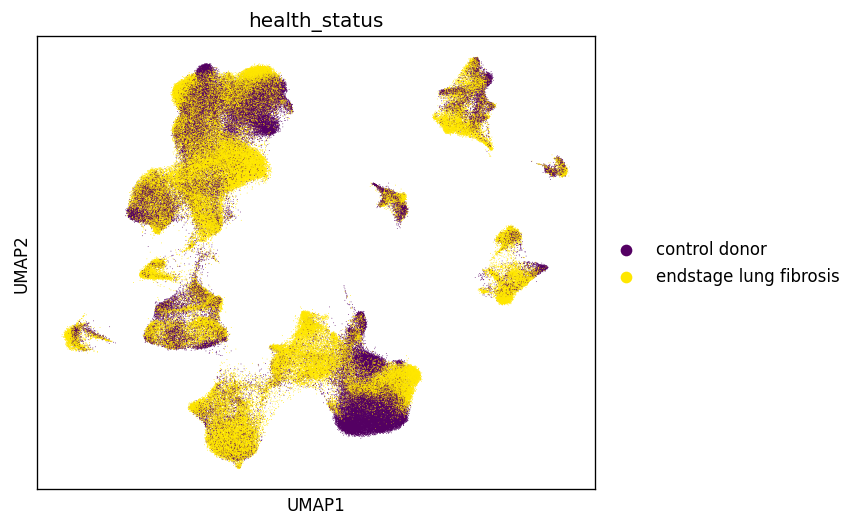

In [29]:
sc.pl.umap(adata, color = ["health_status"], palette = ["#540063", "#FFE700"], size = 1,
           ax = plt.figure(figsize = (6, 5), dpi = 120).gca())

#### Figure 2 c) UMAP of single cell transcriptomic data coloured by cell type

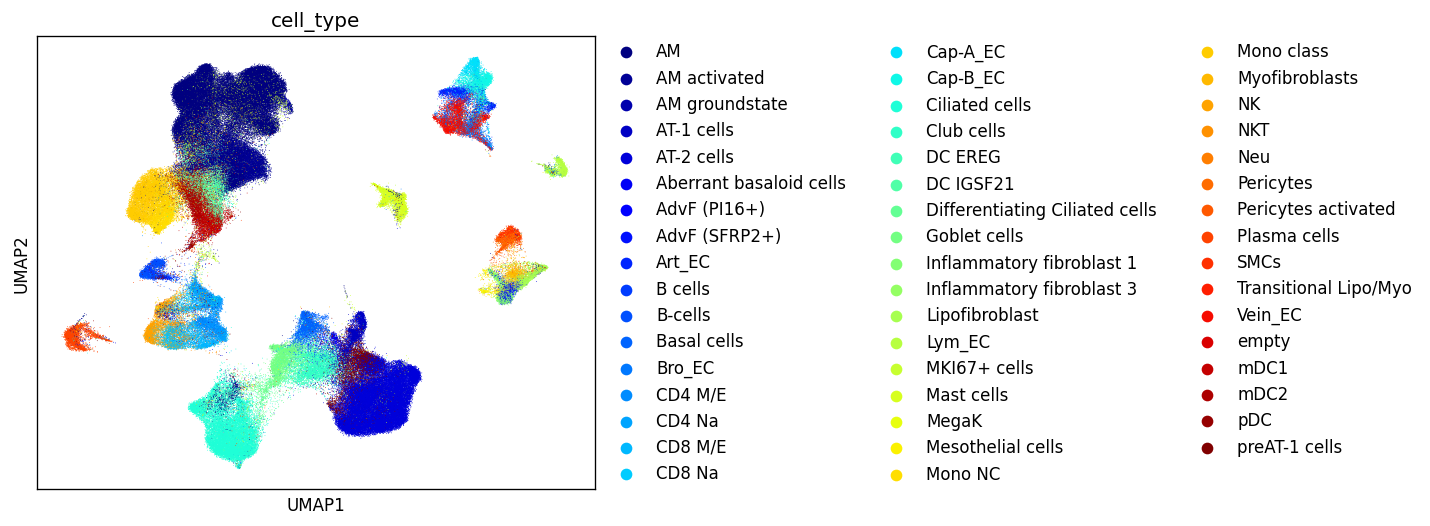

In [30]:
sc.pl.umap(adata, color = ["cell_type"], palette = "jet", size = 1, ax = plt.figure(figsize = (6, 5), dpi = 120).gca())